## Set things up

In [1]:
%matplotlib inline
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [3]:
RAW_DATA_SOURCE = "C:/Users/sbranchett/Data/WiFi_data/WiFiAccessPoint.csv"
CLEAN_DATA_SOURCE = "CleanedWiFiAccessPoint.csv"

## Read in data

In [4]:
def load_wifi_data(path):
    """
    Read WiFi clientCount .csv file and sum the clientCounts over building and timestamp, bucketed to 5 minutes
    
    Input: filepath the .csv file
    Output: Dataframe with "building", "time_bucket", "clientCount"
    Columns "building" generated from "locationHierarchy", and "time_bucket" generated from "timestamp"
    """
    all_data = pd.read_csv(path, delimiter=",")
    all_data = all_data.rename(columns=lambda x: x.strip())  # get rid of extra spaces in column names

    sum_clientCounts = all_data["clientCount"].sum()
    
    # extract building from 'locationHierarchy' string and deal with unknown buildings
    all_data["building"] = all_data["locationHierarchy"].str.split(" > ",expand=True)[1]
    all_data["building"] = all_data["building"].fillna("Unknown")

    # convert timestamp from epoch milliseconds to 5 minute buckets (1000 milliseconds * 60 seconds * 5 minutes)
    all_data["time_bucket"] = all_data["timestamp"].apply(lambda d: 300000*int(d/300000))
    
    # keep only the interesting columns
    all_data = all_data[["time_bucket", "building", "clientCount"]]
    
    # sum data over buildings and time buckets
    all_data = all_data.groupby(["time_bucket", "building"]).sum()  # sort on time first so that new data keeps sequence
    
    assert sum_clientCounts == all_data["clientCount"].sum()  # check that no clientCounts went missing

    return all_data

# if possible read in the cleaned data, otherwise clean the raw data and save
if os.path.isfile(CLEAN_DATA_SOURCE):
    all_data = pd.read_csv(CLEAN_DATA_SOURCE, delimiter=",")
else:
    all_data = load_wifi_data(RAW_DATA_SOURCE)
    all_data.to_csv(CLEAN_DATA_SOURCE)

print(all_data["clientCount"].sum())  # should be 3597531

3597531


In [5]:
all_data = all_data.reset_index().drop("index", axis=1)  # get rid of multiindex for StratifiedShuffleSplit
print(all_data)

         time_bucket               building  clientCount
0      1620991800000      03-Science Center           34
1      1620991800000             05-TNW-BIO            1
2      1620991800000             08-BK-City            2
3      1620991800000   19-Studuitzendbureau           13
4      1620991800000                20-Aula           32
...              ...                    ...          ...
78161  1621608600000                 64-HSL           10
78162  1621608600000          66-Fellowship          126
78163  1621608600000  Katalyse Labaratorium            8
78164  1621608600000                Unknown           32
78165  1621608600000           VLL-LAB(TNO)           11

[78166 rows x 3 columns]


## Separate Test Set stratified over buildings

In [6]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(all_data, all_data["building"]):
    strat_train_set = all_data.loc[train_index]
    strat_test_set = all_data.loc[test_index]

print(strat_train_set)

         time_bucket                           building  clientCount
11688  1621083900000                    37-Sportcentrum           15
61351  1621476000000                         36-ESP-Lab            1
55780  1621431900000                      66-Fellowship          101
26158  1621198200000                          32-OCP-IO           12
34879  1621266900000                             64-HSL           16
...              ...                                ...          ...
50892  1621393500000                            28- WNI            4
33498  1621256100000  36-EWI LB_K t/m 3 & HB_K  t/m 2e           247
4160   1621024500000                      35-Drebbelweg            2
56082  1621434300000                          63-Simona            8
55786  1621432200000                         08-BK-City          670

[62532 rows x 3 columns]


## Create Work days and Student days

In [7]:
uni_hols = (datetime.date(year=2021, month=5, day=5),
            datetime.date(year=2021, month=5, day=13),
            datetime.date(year=2021, month=5, day=14),
            datetime.date(year=2021, month=5, day=24)
           )  # National Holidays and Collective Free days

def roster(date):
    # categorise the days of the academic year at TU Delft between 1 May 2021 and 29 August 2021
    
    if (date > datetime.date(year=2021, month=5, day=16)) and \
       (date < datetime.date(year=2021, month=5, day=22)):
        categorie = "Exam_BSc"
    elif (date > datetime.date(year=2021, month=6, day=15)) and \
         (date < datetime.date(year=2021, month=6, day=19)):
        categorie = "Study_mixed"
    elif (date > datetime.date(year=2021, month=6, day=22)) and \
         (date < datetime.date(year=2021, month=6, day=26)):
        categorie = "Exam_mixed"
    elif (date > datetime.date(year=2021, month=6, day=29)) and \
         (date < datetime.date(year=2021, month=7, day=3)):
        categorie = "Exam"
    elif (date > datetime.date(year=2021, month=8, day=8)) and \
         (date < datetime.date(year=2021, month=8, day=14)):
        categorie = "Exam"
    elif (date > datetime.date(year=2021, month=7, day=4)):
        categorie = "Free"
    else:
        categorie = "Learn"
    return categorie

## Separate predictions and labels

In [8]:
crowd = strat_train_set.drop("clientCount", axis=1)
crowd_labels = strat_train_set["clientCount"].copy()
print(crowd)

         time_bucket                           building
11688  1621083900000                    37-Sportcentrum
61351  1621476000000                         36-ESP-Lab
55780  1621431900000                      66-Fellowship
26158  1621198200000                          32-OCP-IO
34879  1621266900000                             64-HSL
...              ...                                ...
50892  1621393500000                            28- WNI
33498  1621256100000  36-EWI LB_K t/m 3 & HB_K  t/m 2e 
4160   1621024500000                      35-Drebbelweg
56082  1621434300000                          63-Simona
55786  1621432200000                         08-BK-City

[62532 rows x 2 columns]


In [9]:
assert crowd.isnull().values.any() == False  # check there are no missing values

## Build Transformers

In [10]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_day_of_week=True, add_time_of_day=True, add_uni_hols=True, add_weekend=True, add_academic_yr=True):
        self.add_day_of_week = add_day_of_week
        self.add_time_of_day = add_time_of_day
        self.add_uni_hols = add_uni_hols
        self.add_weekend = add_weekend
        self.add_academic_yr = add_academic_yr
        self.num_attribs = ["time_bucket"]
        self.cat_attribs = ["building"]
        if self.add_day_of_week:
            self.num_attribs.extend(["day_of_week"])
        if self.add_time_of_day:
            self.num_attribs.extend(["time_of_day"])
        if self.add_uni_hols:
            self.num_attribs.extend(["hols"])
        if self.add_weekend:
            self.num_attribs.extend(["weekend"])
        if self.add_academic_yr:
            self.cat_attribs.extend(["academic_yr"])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_trans = X.copy()
        if self.add_day_of_week:
            X_trans["day_of_week"] = X["time_bucket"].apply(lambda d: datetime.datetime.fromtimestamp(d/1000).weekday())
        if self.add_time_of_day:
            X_trans["time_of_day"] = X["time_bucket"].apply(lambda d: int(d%86400000))
        if self.add_uni_hols:
            X_trans["hols"] = X["time_bucket"].apply(lambda d: 1. if datetime.datetime.fromtimestamp(d/1000).date() in uni_hols else 0.)
        if self.add_weekend:
            X_trans["weekend"] = X["time_bucket"].apply(lambda d: 1. if datetime.datetime.fromtimestamp(d/1000).weekday() > 4 else 0.)
        if self.add_academic_yr:
            X_trans["academic_yr"] = X["time_bucket"].apply(lambda d: roster(datetime.datetime.fromtimestamp(d/1000).date()))
        return X_trans

In [11]:
add_day_of_week=True
add_time_of_day=True
add_uni_hols=True
add_weekend=True
add_academic_yr=True

In [12]:
# Set up categories for OneHotEncoder.
# This is needed for the transformation of small sets that do not contain all the categories.

buildings = list(set(all_data["building"].values))  # get a list of all buildings
all_categories = [buildings]
if add_academic_yr:
    rosters = ["Exam_BSc", "Study_mixed", "Exam_mixed", "Exam", "Free", "Learn"]  # get a list of all roster categories, could be improved
    all_categories.append(rosters)
    
print(all_categories)

[['08-BK-City', '32a- Learninglab', '03-Science Center', '21-BTUD', '23-CITG', '58-TNW-Zuid', '28- WNI', '34-3ME', '32-OCP-IO', '63-Simona', '43-EGM', 'Katalyse Labaratorium', '36-EWI-HB', '46-P E lab', '62-LR', 'VLL-LAB(TNO)', '66-Fellowship', '31-TBM', '30-O S', '38-Cultureel Centrum', '22-TNW-TN', '25-GreenVillage', '36-EWI LB_K t/m 3 & HB_K  t/m 2e ', '64-HSL', '05-TNW-BIO', '60-LMS', '20-Aula', '36-ESP-Lab', '61-Vliegtuighal', '33-Pulse', '37-Sportcentrum', '19-Studuitzendbureau', '50-TNW-RID', 'Unknown', '35-Drebbelweg', '45-LSL', '30-IKC_ISD-FMVG', '26-Bouwcampus'], ['Exam_BSc', 'Study_mixed', 'Exam_mixed', 'Exam', 'Free', 'Learn']]


In [13]:
# build a pipeline for the numerical attributes
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# build a pipeline for the categorical attributes
cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(categories=all_categories))
])

In [14]:
crowd_attributes = CombinedAttributesAdder(add_day_of_week, add_time_of_day, add_uni_hols, add_weekend, add_academic_yr)
crowd_extra_attribs = crowd_attributes.transform(crowd)
print(crowd_extra_attribs)
print(crowd_attributes.num_attribs)
print(crowd_attributes.cat_attribs)

         time_bucket                           building  day_of_week  \
11688  1621083900000                    37-Sportcentrum            5   
61351  1621476000000                         36-ESP-Lab            3   
55780  1621431900000                      66-Fellowship            2   
26158  1621198200000                          32-OCP-IO            6   
34879  1621266900000                             64-HSL            0   
...              ...                                ...          ...   
50892  1621393500000                            28- WNI            2   
33498  1621256100000  36-EWI LB_K t/m 3 & HB_K  t/m 2e             0   
4160   1621024500000                      35-Drebbelweg            4   
56082  1621434300000                          63-Simona            2   
55786  1621432200000                         08-BK-City            2   

       time_of_day  hols  weekend academic_yr  
11688     47100000   0.0      1.0       Learn  
61351      7200000   0.0      0.0    Ex

In [15]:
# combine the pipelines based on column type
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, crowd_attributes.num_attribs),
    ("cat", cat_pipeline, crowd_attributes.cat_attribs),
])

#SEB
housing_cat = all_data[["building"]]
#cat_encoder = OneHotEncoder()
cat_encoder = OneHotEncoder(categories=[buildings])
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
print(cat_encoder.categories_)
print(type(cat_encoder.categories_))
print(len(cat_encoder.categories_[0]))
print(housing_cat_1hot)

In [16]:
crowd_prepared = full_pipeline.fit_transform(crowd_extra_attribs)  # this gives a sparse matrix!
print(crowd_prepared.toarray())
print(crowd_prepared.toarray().shape)

[[-1.21669404  0.9978856   0.16027025 ...  0.          0.
   1.        ]
 [ 0.98681612 -0.00801088 -1.45222465 ...  0.          0.
   0.        ]
 [ 0.73898445 -0.51095912  0.25726243 ...  0.          0.
   0.        ]
 ...
 [-1.55050812  0.49493736  1.25143222 ...  0.          0.
   1.        ]
 [ 0.75247189 -0.51095912  0.3542546  ...  0.          0.
   0.        ]
 [ 0.74067038 -0.51095912  0.26938645 ...  0.          0.
   0.        ]]
(62532, 49)


## Select and Train a model

In [17]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [18]:
lin_reg = LinearRegression()
lin_reg.fit(crowd_prepared, crowd_labels)

LinearRegression()

In [19]:
# prepare a small data set to test
some_data = crowd.iloc[:5]
some_labels = crowd_labels[:5]

some_data_extra_attribs = crowd_attributes.transform(some_data)
print(some_data_extra_attribs)

some_data_prepared = full_pipeline.fit_transform(some_data_extra_attribs)  # this gives a sparse matrix!
print(some_data_prepared)
print(some_data_prepared.shape)

         time_bucket         building  day_of_week  time_of_day  hols  \
11688  1621083900000  37-Sportcentrum            5     47100000   0.0   
61351  1621476000000       36-ESP-Lab            3      7200000   0.0   
55780  1621431900000    66-Fellowship            2     49500000   0.0   
26158  1621198200000        32-OCP-IO            6     75000000   0.0   
34879  1621266900000           64-HSL            0     57300000   0.0   

       weekend academic_yr  
11688      1.0       Learn  
61351      0.0    Exam_BSc  
55780      0.0    Exam_BSc  
26158      1.0       Learn  
34879      0.0    Exam_BSc  
  (0, 0)	-1.423903258359434
  (0, 1)	0.8429272304235245
  (0, 2)	-0.0053879982922849885
  (0, 4)	1.224744871391589
  (0, 35)	1.0
  (0, 48)	1.0
  (1, 0)	1.267018602074025
  (1, 1)	-0.09365858115816948
  (1, 2)	-1.7968974304770435
  (1, 4)	-0.816496580927726
  (1, 32)	1.0
  (1, 43)	1.0
  (2, 0)	0.9643670997911493
  (2, 1)	-0.5619514869490164
  (2, 2)	0.10237196755341478
  (2, 4)	-0.8164

In [20]:
# check out the predictions
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [-39.58654697  62.21374691  85.51109594  74.10498559  26.04695867]
Labels: [15, 1, 101, 12, 16]


In [21]:
crowd_predictions = lin_reg.predict(crowd_prepared)
lin_mse = mean_squared_error(crowd_labels, crowd_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

97.3095911264158


In [22]:
lin_scores = cross_val_score(lin_reg, crowd_prepared, crowd_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 95.40334995  95.58231466  95.3568397   97.98275818 105.73822232
  92.3158389   97.21878146  98.41494309 100.75946891  94.7687537 ]
Mean: 97.3541270857348
Standard deviation: 3.555710097729978


In [23]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(crowd_prepared, crowd_labels)

crowd_predictions = tree_reg.predict(crowd_prepared)
tree_mse = mean_squared_error(crowd_labels, crowd_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


In [24]:
scores = cross_val_score(tree_reg, crowd_prepared, crowd_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

display_scores(tree_rmse_scores)

Scores: [6.30288942 5.50639945 5.11941207 6.52385552 6.1863616  5.55807626
 5.71605431 5.73731992 6.62988548 5.76950796]
Mean: 5.904976200539675
Standard deviation: 0.4609211962649118


In [25]:
# check out the predictions
print("Predictions:", tree_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [16.  1. 97. 14. 21.]
Labels: [15, 1, 101, 12, 16]


## Let's take a look at how are predictions are doing

In [26]:
print(cat_pipeline.named_steps['one_hot'].get_feature_names)

<bound method OneHotEncoder.get_feature_names of OneHotEncoder(categories=[['08-BK-City', '32a- Learninglab',
                           '03-Science Center', '21-BTUD', '23-CITG',
                           '58-TNW-Zuid', '28- WNI', '34-3ME', '32-OCP-IO',
                           '63-Simona', '43-EGM', 'Katalyse Labaratorium',
                           '36-EWI-HB', '46-P E lab', '62-LR', 'VLL-LAB(TNO)',
                           '66-Fellowship', '31-TBM', '30-O S',
                           '38-Cultureel Centrum', '22-TNW-TN',
                           '25-GreenVillage',
                           '36-EWI LB_K t/m 3 & HB_K  t/m 2e ', '64-HSL',
                           '05-TNW-BIO', '60-LMS', '20-Aula', '36-ESP-Lab',
                           '61-Vliegtuighal', '33-Pulse', ...],
                          ['Exam_BSc', 'Study_mixed', 'Exam_mixed', 'Exam',
                           'Free', 'Learn']])>


In [27]:
test = pd.DataFrame()
test["time_bucket"] = all_data["time_bucket"]
test["building"] = "20-Aula"

test_extra_attribs = crowd_attributes.transform(test)
#print(test_extra_attribs)
#print(crowd_attributes.num_attribs)
#print(crowd_attributes.cat_attribs)

test_prepared = full_pipeline.fit_transform(test_extra_attribs)  # this gives a sparse matrix!
#print(test_prepared)
print(test_prepared.shape)

(78166, 49)


In [28]:
print("Pedictions:", lin_reg.predict(test_prepared))

Pedictions: [-15.80298251 -15.80298251 -15.80298251 ...  51.45843166  51.45843166
  51.45843166]


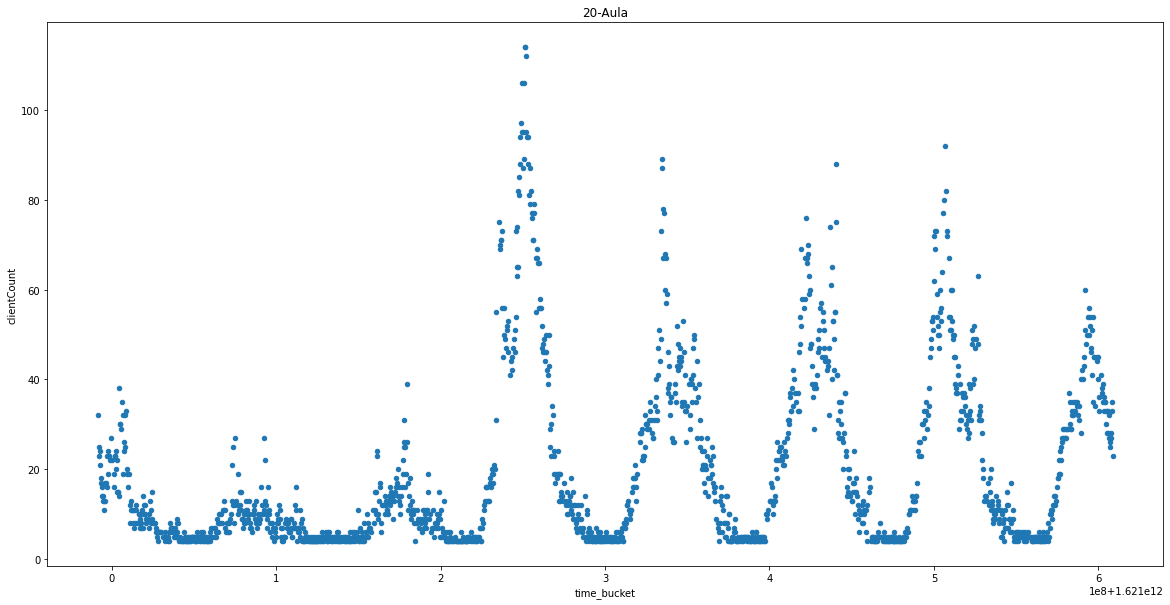

In [29]:
strat_train_set.loc[strat_train_set["building"] == "20-Aula"].plot(kind="scatter", x="time_bucket", y="clientCount", figsize=(20,10)).set_title("20-Aula")

plt.show()